In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#font segoe ui
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'

#### Flow validation

In [2]:
src_dir = r"W:/VUB/_main_research/mHM/flow_data/waterinfo_csv/"
station_locations = pd.read_csv(src_dir + "mhm_flow_stations_coordinates.csv")

#select a station: change the index to select another station
station = station_locations.iloc[1,:]

observed = pd.read_csv(src_dir + f"{station.stat_name}_Q.csv", parse_dates=True, index_col=0, dayfirst=True)
sim_flow_mhm = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mRM_Fluxes_States.nc")
sim_flow_mhm_calib = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mRM_Fluxes_States_015625.nc")

#set -9999 to nan in observed data
observed[observed == -9999] = np.nan

In [4]:
#extracting the simulated flow
mhm_flow_ts = sim_flow_mhm['Qrouted'].sel(lat = station.lat, lon = station.lon, method = 'nearest') 
mhm_flow_ts_calib = sim_flow_mhm_calib['Qrouted'].sel(lat = station.lat, lon = station.lon, method = 'nearest')
sim_flow = mhm_flow_ts.to_dataframe().drop(columns=['lat', 'lon'])
sim_flow_calib = mhm_flow_ts_calib.to_dataframe().drop(columns=['lat', 'lon'])
#flow_df = flow_df.resample('ME').mean()

#resample observed data to monthly
#observed_monthly = observed.resample('ME').mean()

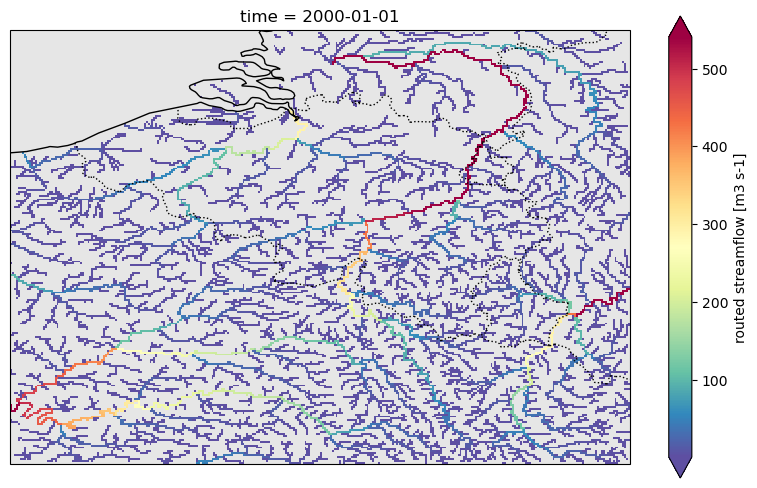

In [32]:
#sim_flow_mhm_calib['Qrouted'][0].plot(cmap='Spectral_r',robust=True)

# Assuming sim_flow_mhm_calib['Qrouted'][0] is your data array and it's correctly set up with coordinates
# Plot data where Qrouted is greater than 20
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
flow_data = sim_flow_mhm_calib['Qrouted'][0].where(sim_flow_mhm_calib['Qrouted'][0] > 0.5)
flow_data.plot(ax=ax, cmap='Spectral_r', robust=True, transform=ccrs.PlateCarree())

# Add a background map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')
ax.add_feature(cartopy.feature.OCEAN, facecolor='0.9')
#ax.add_feature(cartopy.feature.LAKES, facecolor='0.9')
#ax.add_feature(cartopy.feature.RIVERS, edgecolor='blue')  # Changed to make rivers more visible
plt.show()


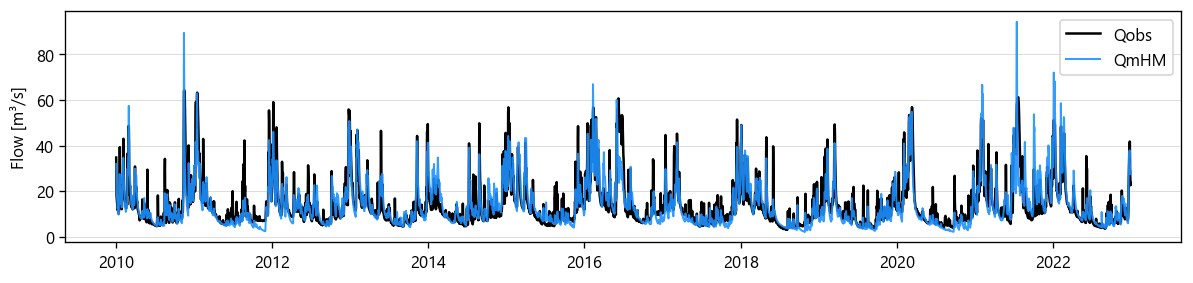

In [34]:
fig, ax = plt.subplots(figsize=(12, 2.5), dpi=120)
#ax2 = ax.twinx()
plt.plot(observed['2010-01-01':'2022-12-31'], c='k',lw=1.5, label='Qobs')
plt.plot(sim_flow['2010-01-01':'2022-12-31'], c='dodgerblue', lw=1.2, label='QmHM', alpha=0.9)
#plt.plot(sim_flow_calib['1995-01-01':'2000-12-31'], c='limegreen', lw=0.9, alpha=0.9, label='QmHM calibrated')

plt.grid(lw=0.5,alpha=0.5,axis='y')
plt.ylabel('Flow [m³/s]')
ax.legend();

In [7]:
#MODEL STATISTICS [Functionalize these]
nse = 1 - (np.sum((sim_flow['Qrouted'] - observed['Q'])**2) / np.sum((observed['Q'] - observed['Q'].mean())**2))
r2 = np.corrcoef(sim_flow['Qrouted'][sim_flow.index.min():sim_flow.index.max()], observed['Q'][sim_flow.index.min():sim_flow.index.max()])[0,1]**2
nse, r2

(0.7939927677571834, 0.7706903401064022)

In [8]:
#MODEL STATISTICS [Functionalize these]
nse = 1 - (np.sum((sim_flow['Qrouted'] - observed['Q'])**2) / np.sum((observed['Q'] - observed['Q'].mean())**2))
r2 = np.corrcoef(sim_flow['Qrouted'][sim_flow.index.min():sim_flow.index.max()], observed['Q'][sim_flow.index.min():sim_flow.index.max()])[0,1]**2
nse, r2

(0.7939927677571834, 0.7706903401064022)

Text(0.5, 0, 'observed flow')

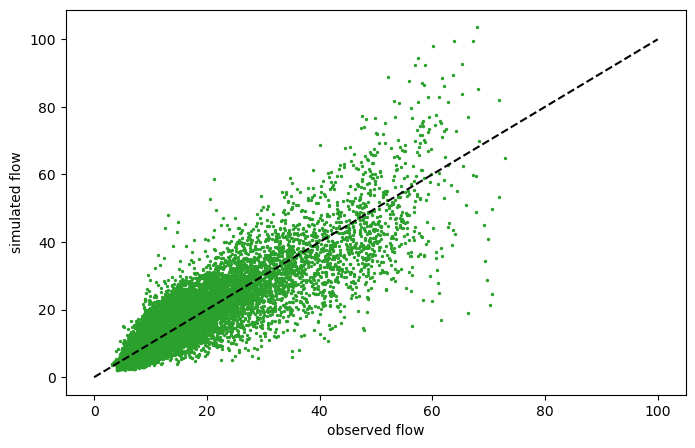

In [9]:
#scatter plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(observed['Q'][sim_flow.index.min():sim_flow.index.max()],
           sim_flow['Qrouted'][sim_flow.index.min():sim_flow_calib.index.max()], s=2,c='C12')
ax.plot([0, 100], [0, 100], 'k--')
ax.set_ylabel('simulated flow')
ax.set_xlabel('observed flow')

### Spatial Datasets

In [10]:
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States_015625.nc")
#resample to month ends
mhm_fluxes= mhm_fluxes.resample(time='ME').mean()
#Gleam root zone soil moisture
gleam_rzsm = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\gleam_EUR_SMrz_EAS_2000_2023.nc")

#### Soil Moisture

In [11]:
#Define ROI
roi = dict(lat=slice(51.5, 50.5), lon=slice(3, 3.5))

#extracting the simulated flow
mhm_sm_ts = mhm_fluxes['SWC_L03'].sel(roi).mean(dim=['lat','lon']).to_dataframe()
gleam_sm_ts = gleam_rzsm['SMrz'].sel(roi).mean(dim=['lat','lon']).to_dataframe()

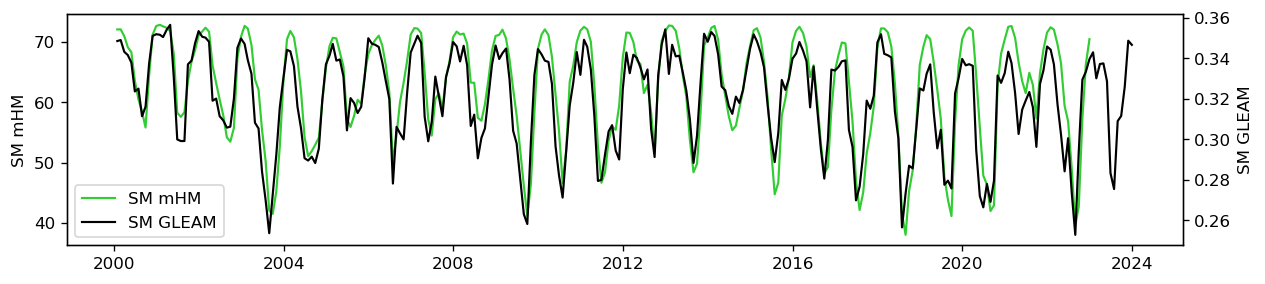

In [12]:
fig, ax = plt.subplots(figsize=(12, 2.5), dpi=120)
ax2=ax.twinx()
#mhm soil moisture
ax.plot(mhm_sm_ts, c='limegreen', lw=1.3, label='SM mHM')
ax2.plot(gleam_sm_ts, c='k', lw=1.3, label='SM GLEAM')
ax.set_ylabel('SM mHM')
ax2.set_ylabel('SM GLEAM')

#collect legend handles and labels
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles + handles2, labels + labels2)


In [13]:
r2 = np.corrcoef(gleam_sm_ts['SMrz'][mhm_sm_ts.index.min():mhm_sm_ts.index.max()],
                  mhm_sm_ts['SWC_L03'][mhm_sm_ts.index.min():mhm_sm_ts.index.max()])[0,1]**2
r2

0.8148722567051568

Text(0.5, 0, 'observed sm')

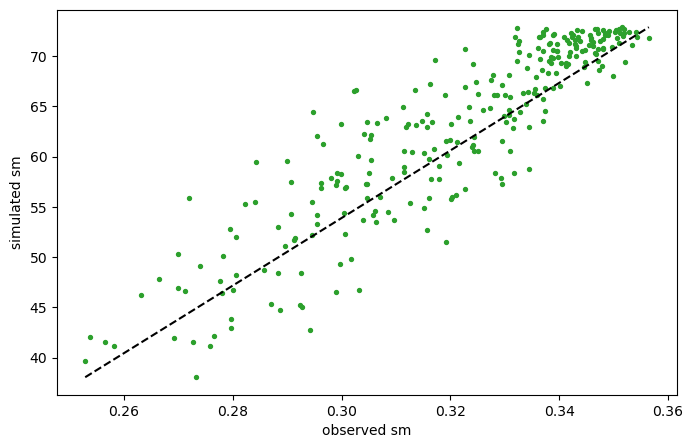

In [14]:
#scatter plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(gleam_sm_ts[mhm_sm_ts.index.min():mhm_sm_ts.index.max()],
           mhm_sm_ts[mhm_sm_ts.index.min():mhm_sm_ts.index.max()], s=8,c='C12')
ax.plot([gleam_sm_ts.min(), gleam_sm_ts.max()], [mhm_sm_ts.min(), mhm_sm_ts.max()], 'k--')
ax.set_ylabel('simulated sm')
ax.set_xlabel('observed sm')

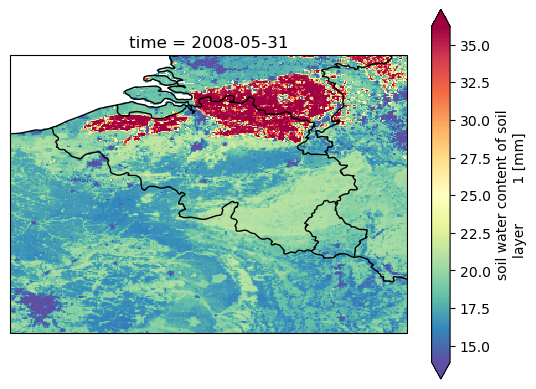

In [30]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
sm_data = mhm_fluxes['SWC_L01'][100]
sm_data.plot(ax=ax, cmap='Spectral_r', robust=True, transform=ccrs.PlateCarree())

# Add a background map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')